# Requirements

In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the current **close price** of the Dow Jones Industrial Average index. To accomplish this use data from the past 7 days, which includes numeric information and news information. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast one future step for the index price (the following day).


## The DIJA Dataset

This dataset consists of daily price records for the value of the Dow Jones Industrial Average index. The dataset includes the following attributes:

- Date - date in the format YYYY-MM-DD,
- Open - open price of the index on the specified date
- Close - close price of the index on the specified date
- High - high price of the index on the specified date
- Low - low price of the index on the specified date
- Volume - number of trades



## The Reddit News Dataset

This dataset consists of news headlines for a certain date that might impact the price:

- Date - date in the format YYYY-MM-DD,
- News - news headline scraped from Reddit

<b>Note: You might have multiple headlines for each date. The number of news per date might not be the same for each date. <b>

Load the datasets into a `pandas` data frame.

In [74]:
data1 = pd.read_csv("DJIA_table.csv")
data2 = pd.read_csv("RedditNews.csv")

Merge the datasets (be careful you can get multiple rows per date which is not desirable)

In [75]:
def drop_data(data:pd.DataFrame, columns:list):
  data_copy = data.copy()
  data_copy.drop(columns, axis=1, inplace=True)
  return data_copy

In [76]:
data1.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [77]:
data1 = drop_data(data1,['Open', 'High', 'Low','Volume'])

In [78]:
aggregated_data2 = data2.groupby('Date')['News'].apply(lambda x: ' ; '.join(x)).reset_index()
aggregated_data2

,Date,News
0,2008-06-08,b'Nim Chimpsky: The tragedy of the chimp who t...
1,2008-06-09,b'United States quits Human Rights Council' ; ...
2,2008-06-10,"b'Oil shortage a myth, says industry insider' ..."
3,2008-06-11,b'BBC uncovers lost Iraq billions' ; b'War Cri...
4,2008-06-12,"b'Did US attack Pakistan last night? ""Pakistan..."
...,...,...
2938,2016-06-27,Barclays and RBS shares suspended from trading...
2939,2016-06-28,"2,500 Scientists To Australia: If You Want To ..."
2940,2016-06-29,Explosion At Airport In Istanbul ; Yemeni form...
2941,2016-06-30,Jamaica proposes marijuana dispensers for tour...


In [79]:
data1['Date'] = pd.to_datetime(data1['Date'])
aggregated_data2['Date'] = pd.to_datetime(aggregated_data2['Date'])

In [80]:
data = data1.merge(aggregated_data2, on='Date')
data

,Date,Close,News
0,2016-07-01,17949.36914,A 117-year-old woman in Mexico City finally re...
1,2016-06-30,17929.99023,Jamaica proposes marijuana dispensers for tour...
2,2016-06-29,17694.67969,Explosion At Airport In Istanbul ; Yemeni form...
3,2016-06-28,17409.72070,"2,500 Scientists To Australia: If You Want To ..."
4,2016-06-27,17140.24023,Barclays and RBS shares suspended from trading...
...,...,...,...
1984,2008-08-14,11615.92969,b'All the experts admit that we should legalis...
1985,2008-08-13,11532.95996,b' U.S. refuses Israel weapons to attack Iran:...
1986,2008-08-12,11642.46973,b'Remember that adorable 9-year-old who sang a...
1987,2008-08-11,11782.34961,b'Why wont America and Nato help us? If they w...


In [81]:
data.sort_index(inplace=True)

## Feauture Extraction


1. DIJA Table
Apply a lag of one, up to 7 days to each feature, creating a set of features representing the index price from the previous 7 days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

2. Reddit News Table
Create a numeric representation for the news (for example average embedding or average sentiment). <b> You must create lags of the news features as well since we will not know the news for the future. </b>

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [82]:
target = ['Close']
all = ['Close','Sentiment']

In [83]:
lags = range(7, 0, -1)
list(lags)

[7, 6, 5, 4, 3, 2, 1]

In [84]:
data['Sentiment'] = data['News'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [85]:
data = drop_data(data,['News'])

In [86]:
for lag in lags:
    for column in all:
        data[f"{column}_{lag}"] = data[column].shift(lag)

In [87]:
data.dropna(axis=0, inplace=True)

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [88]:
X, y = data.drop(columns=['Close','Date']), data[target]

In [89]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, shuffle=False)

## Feauture Scaling
Scale the extracted features using an appropriate scaler if needed.

In [90]:
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

## Feature Reshaping

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

In [107]:
lag = 5
(train_X.shape[0], lag, (train_X.shape[1] // lag))

(1585, 5, 3)

In [108]:
train_X = train_X.reshape((train_X.shape[0], lag, (train_X.shape[1] // lag)))
test_X = test_X.reshape((test_X.shape[0], lag, (test_X.shape[1] // lag)))

## Long Short-Term Memory (LSTM) Network


Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [131]:
model = Sequential([
    Input((train_X.shape[1], train_X.shape[2],)),
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu"),
    Dense(1, activation="linear")
])

Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [142]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

In [143]:
history = model.fit(train_X, train_y, validation_split=0.20, epochs=5, batch_size=64, shuffle=False)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 863989.0000 - mean_squared_error: 863989.0000 - val_loss: 860157.0625 - val_mean_squared_error: 860157.1875
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 877177.0625 - mean_squared_error: 877177.0625 - val_loss: 644583.1875 - val_mean_squared_error: 644583.1875
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 757929.6875 - mean_squared_error: 757929.6875 - val_loss: 624500.4375 - val_mean_squared_error: 624500.4375
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 693736.5000 - mean_squared_error: 693736.5000 - val_loss: 586424.3750 - val_mean_squared_error: 586424.3750
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 658365.3750 - mean_squared_error: 658365.3750 - val_loss: 544453.2500 - val_mean_squared_error: 544453.2500


Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

<Axes: >

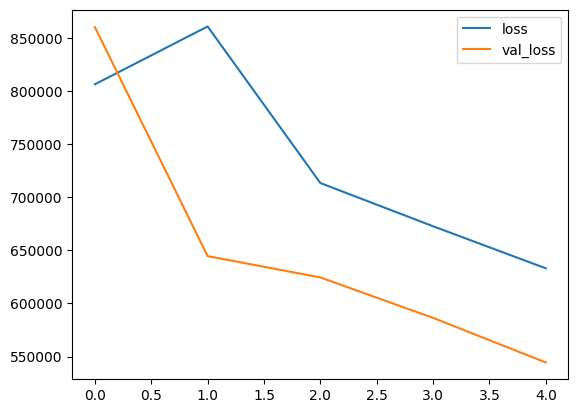

In [144]:
import seaborn as sns
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

Use the trained model to make predictions for the test set.

In [145]:
pred_y = model.predict(test_X)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [146]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), r2_score(test_y, pred_y))

(660.5801391601562, 699407.375, 0.4859405755996704)

Create a line plot in order to compare the actual and predicted mean temperatures for the test set.

In [150]:
pred_y = pred_y.flatten() if len(pred_y.shape) > 1 else pred_y
test_y = test_y.squeeze()


<Axes: xlabel='None'>

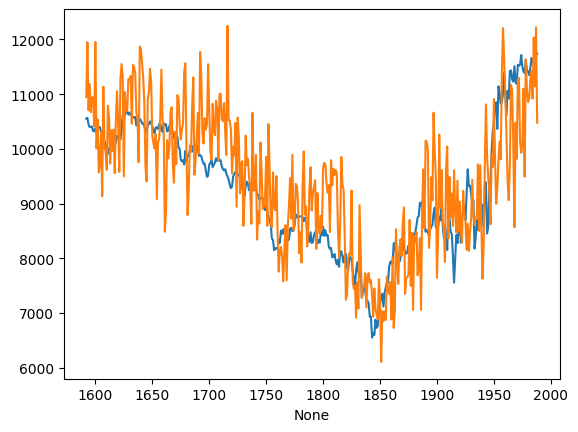

In [151]:
sns.lineplot(x=test_y.index, y=test_y.values)
sns.lineplot(x=test_y.index, y=pred_y.flatten())